In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Inicijalizacija Spark sesije
spark = SparkSession.builder.appName("StockLinearRegression").getOrCreate()

# Definisanje seme koja ce se koristiti za podatke
schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True),
    StructField("MarketCap", DoubleType(), True)
])

# Citanje podataka iz fajlova koji se nalaze na zadatoj putanji pomocu spark streaming-a
streaming_df = spark.readStream \
    .option("header", "true") \
    .schema(schema) \
    .csv("dbfs:/FileStore/novi")

# Sladistenje podataka u memoriji i to pod imenom upita 'eth_prices_usd'
query = streaming_df.writeStream \
    .queryName("eth_prices_usd") \
    .format("memory") \
    .outputMode("append") \
    .start()

In [0]:
query.stop()

In [0]:
df = spark.table("eth_prices_usd")
df.show()

+----------+-------+-------+-------+-------+-----------+-----------+
|      Date|   Open|   High|    Low|  Close|     Volume|  MarketCap|
+----------+-------+-------+-------+-------+-----------+-----------+
|2024-02-05|2289.79|2338.41|2269.11|2301.83| 236610.412| 236610.412|
|2024-02-04| 2296.5| 2311.0| 2266.0|2289.79|171232.0444|171232.0444|
|2024-02-03|2309.07|2329.98|2292.75|2296.49| 133232.845| 133232.845|
|2024-02-02|2304.28|2324.74|2281.94|2309.06| 238230.511| 238230.511|
|2024-02-01|2283.15|2311.72| 2240.0|2304.28|310997.4538|310997.4538|
|2024-01-31| 2343.0| 2351.6|2263.57|2283.14|397116.1859|397116.1859|
|2024-01-30|2317.61|2391.98| 2297.0|2343.01|372879.5791|372879.5791|
|2024-01-29| 2256.9|2322.34| 2233.8| 2317.6|305528.0776|305528.0776|
|2024-01-28|2267.94|2308.24|2239.89| 2256.9|209326.9087|209326.9087|
|2024-01-27|2267.67|2282.94| 2251.4|2267.94|145109.3836|145109.3836|
|2024-01-26|2218.64|2282.36|2195.84|2267.68|363566.4255|363566.4255|
|2024-01-25|2235.02|2242.89| 2171.

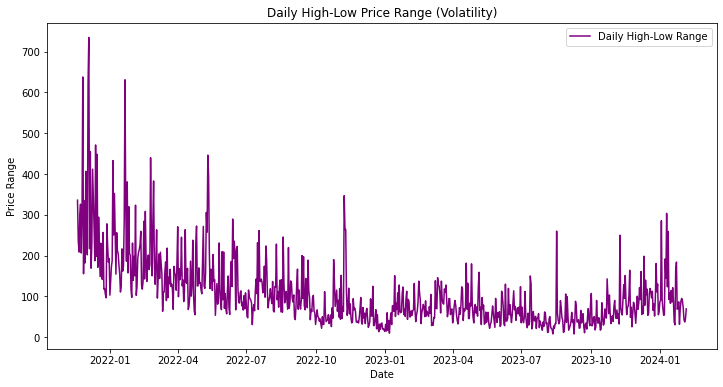

In [0]:
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, DateType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
import pandas as pd

df = spark.table("eth_prices_usd")
df = df.orderBy("Date")

# High-Low Price Range (Volatility)-  promenljivosti cena 
# Analiza se fokusira na dnevni raspon cene - razliku između najviše i najniže cene u jednom danu
# raspon cene je mera volatilnosti - veći raspon ukazuje na veću volatilnost tog dana.
df = df.withColumn("HighLowRange", col("High") - col("Low"))

df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['HighLowRange'], label='Daily High-Low Range', color='purple')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.title('Daily High-Low Price Range (Volatility)')
plt.legend()
plt.show()


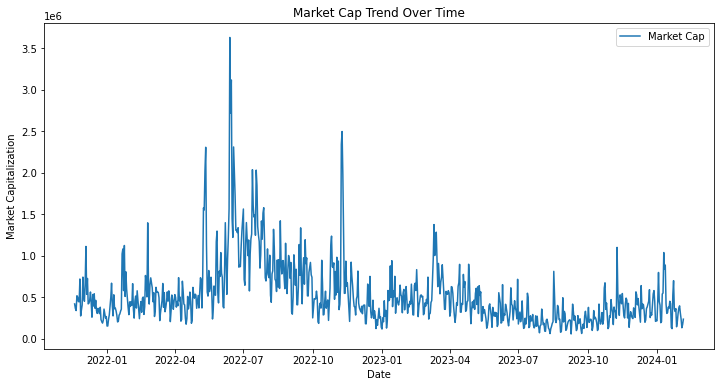

In [0]:
# Market Cap Trend
df_pd = df.toPandas()

# Plotovanje market cap-a
plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['MarketCap'], label='Market Cap')
plt.xlabel('Date')
plt.ylabel('Market Capitalization')
plt.title('Market Cap Trend Over Time')
plt.legend()
plt.show()


+--------------------------------------------------------------+------------+
|features                                                      |MarketCap   |
+--------------------------------------------------------------+------------+
|[502811.7902,518501.3338,340206.3203,365584.578,420045.0897]  |448727.0306 |
|[448727.0306,502811.7902,518501.3338,340206.3203,365584.578]  |445868.2434 |
|[445868.2434,448727.0306,502811.7902,518501.3338,340206.3203] |720245.1612 |
|[720245.1612,445868.2434,448727.0306,502811.7902,518501.3338] |275326.5202 |
|[275326.5202,720245.1612,445868.2434,448727.0306,502811.7902] |346471.3551 |
|[346471.3551,275326.5202,720245.1612,445868.2434,448727.0306] |406881.2284 |
|[406881.2284,346471.3551,275326.5202,720245.1612,445868.2434] |743024.4662 |
|[743024.4662,406881.2284,346471.3551,275326.5202,720245.1612] |508198.3105 |
|[508198.3105,743024.4662,406881.2284,346471.3551,275326.5202] |451861.9545 |
|[451861.9545,508198.3105,743024.4662,406881.2284,346471.3551] |

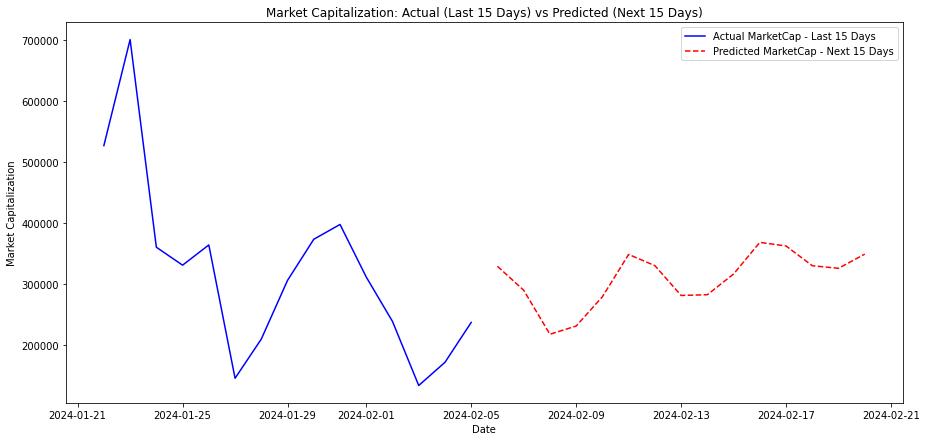

In [0]:
num_lags = 5
# Regresija koja ce na osnovu podataka koje imamo da nam generise ishod za narednih 15dana
# Ovde dodajemo nove kolone u nas DataFrame kako bismo imali koliki je prosek market cap-a u prethodnih 5dana, lag1, lag2, lag3...
for i in range(1, num_lags + 1):
    df = df.withColumn(f"lag_{i}", lag("MarketCap", i).over(Window.orderBy("Date")))

#Izbacujemo redove sa null vrednostima
df = df.na.drop()

# Grupisemo sve lag-ove u jednu kolonu koju cemo koristiti za model
# df_final ->           
#       |features|        |Market cap|
# +--------------------+--------+
# [1505897.92612,10...|1095927.10403|
vectorAssembler = VectorAssembler(inputCols=[f"lag_{i}" for i in range(1, num_lags + 1)], outputCol="features")
df_vector = vectorAssembler.transform(df)
df_final = df_vector.select("features", "MarketCap")
df_final.show(truncate=False)


# Treniranje modela
lr = LinearRegression(featuresCol="features", labelCol="MarketCap")
lr_model = lr.fit(df_final)


# Priprema podataka za predvidjanje i vizuelizaciju
# Uzima se poslednji 10 poznatih podataka
last_rows = df.orderBy("Date", ascending=False).take(num_lags)
# Uzima samo low price iz celog reda i sortira podatke tako da su hronoloski poredjani  (od najstarijeg do najnovijeg).
last_features = [row.MarketCap for row in last_rows][::-1]

# Predvidja vrednosti u narednih 15 dana na osnovu prethodnih
future_predictions = []
num_future_days = 15
for _ in range(num_future_days):
    last_features_vector = Vectors.dense(last_features[-num_lags:])
    last_features_df = spark.createDataFrame([(last_features_vector,)], ["features"])

    next_prediction = lr_model.transform(last_features_df).collect()[0]['prediction']
    last_features.append(next_prediction)
    future_predictions.append(next_prediction)


# Uzimanje poslednji 15 dana koji su nam poznati i kod za vizuelizaciju
last_15_days_df_pd = df_pd.tail(15)
last_actual_date = last_15_days_df_pd['Date'].iloc[-1]
future_dates = [last_actual_date + pd.DateOffset(days=i) for i in range(1, 16)]


plt.figure(figsize=(15, 7))
plt.plot(last_15_days_df_pd['Date'], last_15_days_df_pd['MarketCap'], label='Actual MarketCap - Last 15 Days', color='blue')
plt.plot(future_dates, future_predictions, label='Predicted MarketCap - Next 15 Days', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Market Capitalization')
plt.title('Market Capitalization: Actual (Last 15 Days) vs Predicted (Next 15 Days)')
plt.legend()
plt.show()

In [0]:
spark.stop()